In [1]:
#importing stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt # wavelet transformation
from scipy import linalg as la
from scipy import fft
from scipy import signal
from sklearn.decomposition import PCA

# Respiratory rate estimation
The goal of this project is to estimate Respiratory Rate Per Minute (RPM) and Respiratory Rate Variability (RRV) from time series measurements of mechanical quantities such as linear acceleration and angular velocity; said measurements are relative to a Inertial Measurement Unit (IMU) coherently attached to the patient itself or to some structure mechanically connected to him/her (such as the bed).
## Datasets
The available datasets provide measurement of the three spatial components of the linear acceleration vector, angular velocity vector and magnetic field vector (all of them with respect to some previous calibration), plus the spatial orientation of the device given by the quaternion components, and the sampling rate of the given dataset.
### First dataset
The first dataset we will explore is the `center_sternum.txt` dataset; this dataset has been acquired with the IMU placed directly on the patient's sternum, who was lying supine on the bed. Let's proceed with some initial explorative analysis:

In [2]:
df_init=pd.read_csv("center_sternum.txt",sep=None,engine='python') # load the dataset
df_init

# first things first, we load the center_sternum dataset and add a time column as index


,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
16502,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
16503,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502
16504,5,200,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124,0.648973,0.381329,-0.637348,0.164953


In [3]:
# sampling rate is constant through the acquisition: this can be easily checked with a statistical analysis of the column:
print(df_init['Log Freq'].describe())

count    16506.0
mean       200.0
std          0.0
min        200.0
25%        200.0
50%        200.0
75%        200.0
max        200.0
Name: Log Freq, dtype: float64


In [4]:
sampling_rate = 200 # calibration tells us the sampling rate
df_init['time_s'] = np.arange(0,df_init.shape[0])/sampling_rate # let's construct the time axis, with each sampling separated by a 200th of a second (because sampling rate is 100 Hz)
df_init=df_init.set_index('time_s')

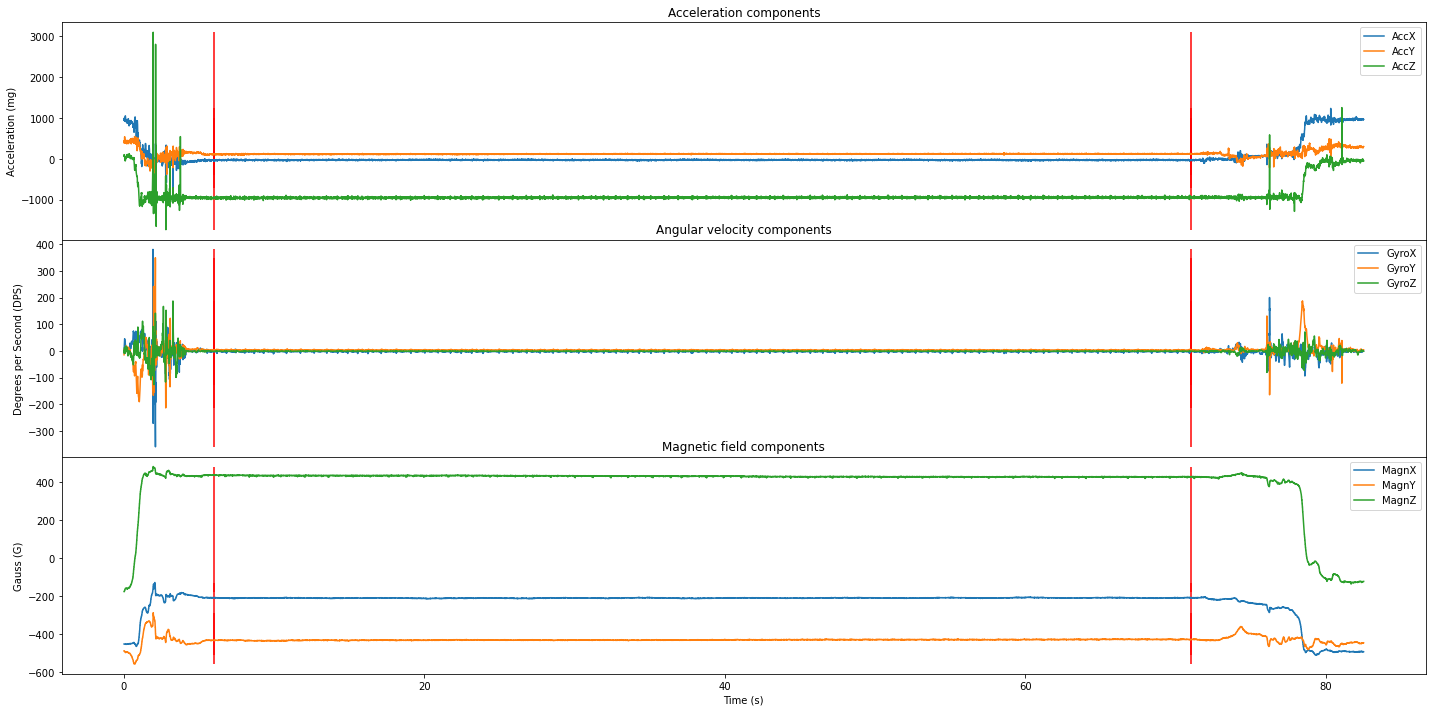

In [5]:
# now let's look at the acceleration vector by plotting its three components
acc_columns = ['AccX','AccY','AccZ']
gyro_columns = ['GyroX','GyroY','GyroZ']
magn_columns = ['MagnX','MagnY','MagnZ']

timestamp1 = 6
timestamp2 = 71

fig,axs = plt.subplots(3,1,sharex=True,figsize=[20,10],gridspec_kw={'hspace': 0})
# plot the acceleration vectors
axs[0].set_title('Acceleration components')
for acc in acc_columns:
    axs[0].vlines(timestamp1,df_init[acc].min(),df_init[acc].max(),color='red')
    axs[0].vlines(timestamp2,df_init[acc].min(),df_init[acc].max(),color='red')
    axs[0].plot(df_init.index,df_init[acc],label=acc)
    axs[0].set_ylabel('Acceleration (mg)')
# plot the angular velocity components
axs[1].set_title('Angular velocity components')
for gyro in gyro_columns:
    axs[1].vlines(timestamp1,df_init[gyro].min(),df_init[gyro].max(),color='red')
    axs[1].vlines(timestamp2,df_init[gyro].min(),df_init[gyro].max(),color='red')
    axs[1].plot(df_init.index,df_init[gyro],label=gyro)
    axs[1].set_ylabel('Degrees per Second (DPS)')
# plot the magnetic field components
axs[2].set_title('Magnetic field components')
for magn in magn_columns:
    axs[2].vlines(timestamp1,df_init[magn].min(),df_init[magn].max(),color='red')
    axs[2].vlines(timestamp2,df_init[magn].min(),df_init[magn].max(),color='red')
    axs[2].plot(df_init.index,df_init[magn],label=magn)
    axs[2].set_ylabel('Gauss (G)')
for ax in axs:   ax.legend()
axs[-1].set_xlabel('Time (s)')
fig.tight_layout()
plt.show()

In the plot shown above, the three components for each acquired vector quantity have been plotted, along with a potential time window corresponding to the signal we're interested in.

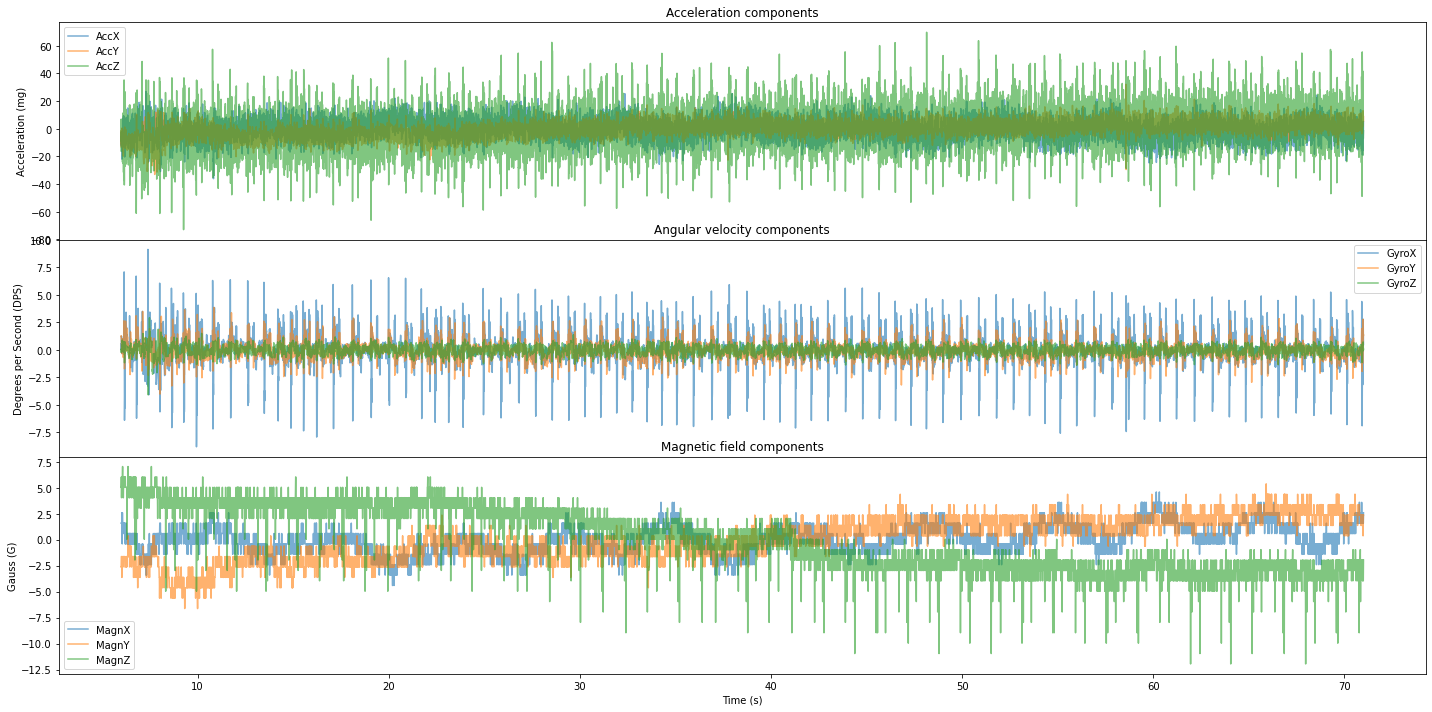

In [6]:
df =df_init.loc[timestamp1:timestamp2] # working on the 6s-71s subset
df = df-df.mean()

fig,axs = plt.subplots(3,1,sharex=True,figsize=[20,10],gridspec_kw={'hspace': 0})
alpha = 0.6
# plot the acceleration vectors
axs[0].set_title('Acceleration components')
for acc in acc_columns:
    axs[0].plot(df.index,df[acc],label=acc,alpha=alpha)
    axs[0].set_ylabel('Acceleration (mg)')
# plot the angular velocity components
axs[1].set_title('Angular velocity components')
for gyro in gyro_columns:
    axs[1].plot(df.index,df[gyro],label=gyro,alpha=alpha)
    axs[1].set_ylabel('Degrees per Second (DPS)')
# plot the magnetic field components
axs[2].set_title('Magnetic field components')
for magn in magn_columns:
    axs[2].plot(df.index,df[magn],label=magn,alpha=alpha)
    axs[2].set_ylabel('Gauss (G)')
for ax in axs:   ax.legend()
axs[-1].set_xlabel('Time (s)')
fig.tight_layout()
plt.show()

# Wavelet transformation

<center><img src="img/wavelet_analysis.png" width="450"/></center>
<center>Image taken from 
<a href="https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442">this</a>
 article.</center>

Standard Fourier Transform decomposes the signal in plane waves with fixed frequency, and infinite time span; by looking at the resulting coefficients, we cannot extrapolate any information regarding time-localized events and time dependent frequency information. To perform a *Time-Frequency Analysis* one has to deploy different mathematical machines; one could, for example, perform a FT over a restricted time window of the original signal (*Short time Fourier Transform*), or, better yet, decompose the signal into a 2-dimensional basis set of wave packets, localized at some point in time $\tau$. By computing the correlation between the signal and a wave packet of a given frequency localized at a given instant, we obtain a 2D transformation carrying both time and frequency information: this is exactly what the *wavelet transform* does.
The mathematical definition of a *continuous wavelet transform* is the following:
$$
cwt(\tau,s) = \frac{1}{\sqrt{|s|}} \int_{-\infty}^{+\infty} x(t) \psi(\frac{t-\tau}{s}) dt
$$
Where $\psi$ is the *mother wavelet*, i.e. the specific type of wave we convolve with our signal, and $s$ is the *scale factor* of such mother wavelet. The suitable type of wavelet depends on the problem at hand, and the scale factor basically determines the frequency of said wavelet packet.

<center><img src="img/Continuous_wavelet_transform.gif" width="450"/></center>
<center>Image taken from 
<a href="https://en.wikipedia.org/wiki/Continuous_wavelet_transform">Wikipedia</a>.</center>

## Wavelets

In our study case, we employ the <a href="https://pywavelets.readthedocs.io/en/latest/">Pywavelets</a> `pywt` package that implements the continuous wavelet transform and several types of wavelets to perform the transformation with. Let's start by obtaining the list of available wavelets:

In [45]:
c_wvlst=pywt.wavelist(kind='continuous')
print(c_wvlst)

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


Official <a href="https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#continuous-wavelet-families">Pywavelets documentation</a> provides a more detailed explanation of the previously printed wavelets, along with their mathematical formulation. Each of these wavelets has a "central frequency" $f_C$, i.e. the wave packet's peak frequency when its scale factor is set to 1. For instance, let's pick the Morlet wavelet `morl`, defined in the documentation as
$$
\psi_{Morlet}(t) = e^{-t^2/2}\cos(5t)
$$
When scaled by a factor of 1, this (and any other) wavepacket is evaluated within a range where it's assumed to be non-zero: when selecting a larger scale factor, the wavelet's range is extended by the same factor, making it more sensible to lower frequencies in the signal. Pywavelets allow us to explore these properties and the wavelet we've chosen:


Wavelet's name:  morl
Wavelet's upper bound:  8.0
Wavelet's lower bound:  -8.0
Is the wavelet biorthogonal?  False
Is the wavelet symmetric?  symmetric


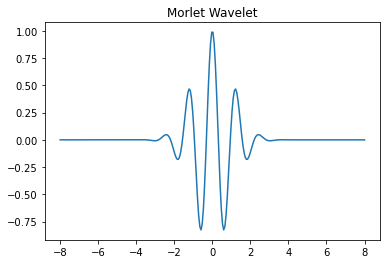

In [58]:
def get_wavelet_description(name):
    # initialize a wavelet object
    wav = pywt.ContinuousWavelet(name)
    wavy,wavx=wav.wavefun()
    print("Wavelet's name: ",wav.name)
    print("Wavelet's upper bound: ",wav.upper_bound)
    print("Wavelet's lower bound: ",wav.lower_bound)
    print("Is the wavelet biorthogonal? ",wav.biorthogonal)
    print("Is the wavelet symmetric? ",wav.symmetry)
    print("Central frequency: ",pywt.scale2frequency(wav,1)) #scale2frequency is a pywt function that returns the frequency at a given scale

    fig,ax = plt.subplots()
    ax.set_title('Morlet Wavelet')
    ax.plot(wavx,wavy)
    plt.show()

get_wavelet_description('morl')

Note: the frequency returned by the function `scal2frequency` is a *pseudy-frequency* $\hat{f}$: it's only equal to the real physical frequency if the sampling period is assumed to be 1 s (sampling frequency of 1 Hz). In order to get the corresponding physical central frequency of it we need to multiply it by the sampling frequency:
$$
f_C = \hat{f_C}f_{sampling}
$$
Since the frequency of a wavelet is inversely proportional to the scale factor $f(s)=\hat{f_C}f_{sampling}/s$, in order to find the scale factor corresponding to a specific frequency we explicitate:
$$
s(f) = \frac{\hat{f_C}f_{sampling}}{f}
$$

This helps us set a minimum scale value, corresponding to the maximum frequency which turns out to be half the sampling frequency as per Nyquist-Shannon's theorem:

$$
s_{min} = 2\hat{f_C}
$$

Since we are looking for the Respiratory Rate, that usually spans between 12 and 20 BPM (0.2-0.33 Hz), we can also look for a maximum scale value that bring useful information, by looking the scale corresponding to, let's say, 0.1 Hz:

$$
s_{max} = \frac{\hat{f_C}f_{sampling}}{0.1}
$$

162.5
1.625
1625.0
0.65


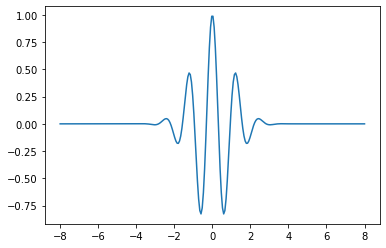

In [44]:

wav = pywt.ContinuousWavelet('morl') #if we try with mexican hat mexh frequency resolution SUCKS ASS
print(pywt.scale2frequency(wav,1)*sampling_rate)
min_scale = pywt.scale2frequency(wav,1)*sampling_rate/100
print(min_scale)
max_scale = pywt.scale2frequency(wav,1)*sampling_rate/0.1
print(max_scale)

print(pywt.scale2frequency(wav,250)*sampling_rate)

wavy,wavx=wav.wavefun()
plt.plot(wavx,wavy)


In [27]:
data_in = df['AccX'].values
data_in = (data_in-np.mean(data_in))/np.std(data_in)
scales = np.linspace(min_scale,max_scale,500)
coefs,cwt_freq=pywt.cwt(data_in,scales,wav,sampling_period=1/sampling_rate) # result is (n_scales,n_points) np.array. coefs[0,:] are the coefficient for the first scale
                                                                            # which is the smaller one (higher frequency)
                                                                            # cwt_freq is a frequency array, corresponding to the scales array but transformed to a frequency

In [30]:
max_indeces=np.argmax(np.abs(coefs),axis=0)
max_scales=[scales[i] for i in max_indeces]
# print(max_scales)

gradient = np.gradient(np.abs(coefs))
print(gradient[0].shape) #gradient[0] is the component of the gradient along the 0th dimension (scale)
print(gradient[1].shape) #along the time dimension
max_indeces = np.argmin(gradient[0],axis=0)

(500, 13001)
(500, 13001)


In [36]:
def cwt_with_plot(dataframe,columnname,wavename,sampling_rate,min_freq=0.1,max_freq=None,Nscales=500):

    """
    Helper function to perform CWT transformation and plot the result.
    """
    
    # PERFORM CWT TRANSFORMATION
    if max_freq == None: max_freq = sampling_rate/2 # infer maximum frequency from nyquist-shannon if not specified
    wav = pywt.ContinuousWavelet(wavename)
    min_scale = pywt.scale2frequency(wav,1)*sampling_rate/max_freq
    max_scale = pywt.scale2frequency(wav,1)*sampling_rate/min_freq
    scales=np.linspace(min_scale,max_scale,Nscales)
    coefs,cwt_freq=pywt.cwt(dataframe[columnname].values,scales,wav,sampling_period=1/sampling_rate) # result is (n_scales,n_points) np.array. coefs[0,:] are the coefficient for the first scale
                                                                            # which is the smaller one (higher frequency)
                                                                            # cwt_freq is a frequency array, corresponding to the scales array but transformed to a frequency

    # PLOTTING
    fig,axs = plt.subplots(2,1,figsize=[20,8],sharex=True)
    fig.suptitle(columnname+' CWT spectrogram')
    fig.subplots_adjust(hspace=0)

    axs[0].set_ylabel('Wavelet Frequency (Hz)')
    pos = axs[0].imshow(np.abs(coefs),aspect='auto',cmap='plasma')
    yticks = np.arange(0,scales.size,int(scales.size/10))
    yticklabels = ["{:.2f}".format(cwt_freq[i]) for i in yticks]
    axs[0].set_yticks(yticks)
    axs[0].set_yticklabels(yticklabels)
    xticks = np.linspace(0,dataframe.index.size-1,10,dtype=int)
    xticklabels = ["{:.4}".format(i) for i in dataframe.index[xticks]]
    axs[1].plot(dataframe[columnname].values)
    axs[1].set_xticks(xticks)
    axs[1].set_xticklabels(xticklabels)
    axs[1].set_xlabel('Time (s)')
    fig.tight_layout()
    plt.show()

    return coefs,cwt_freq,fig,axs


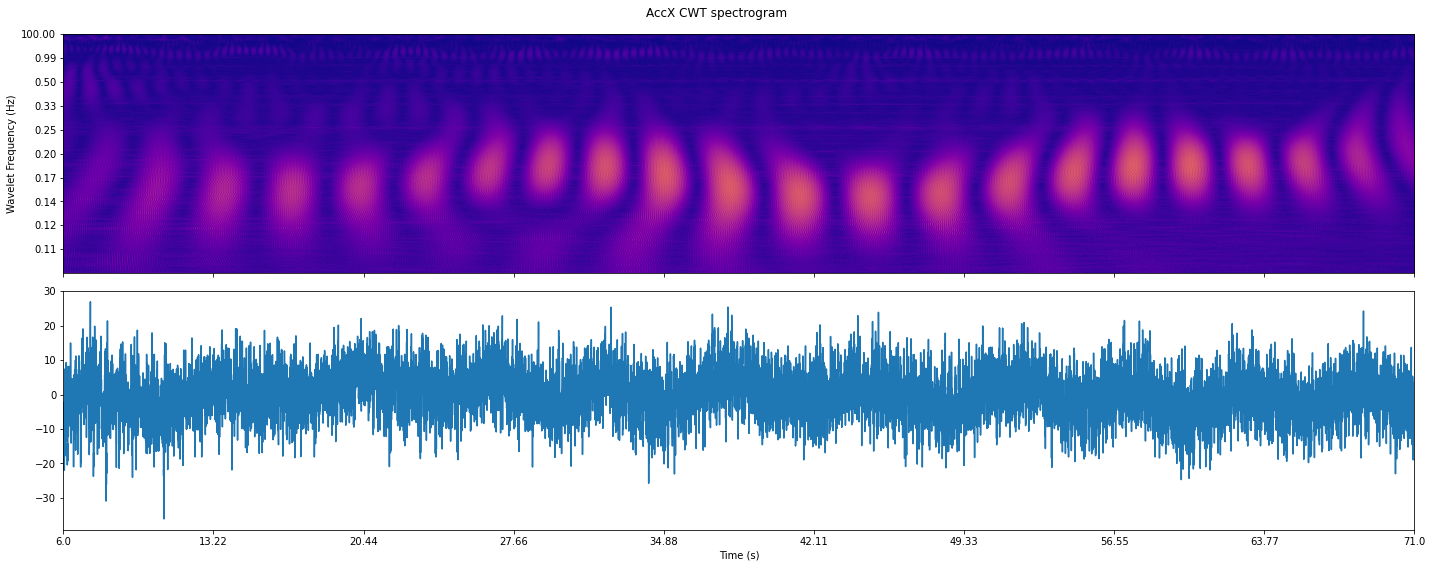

In [35]:
coefs,cwt_freq,fig,axs=cwt_with_plot(df,'AccX','morl',sampling_rate)


### *Discrete Wavelet Transformation* (DWT) and *Multi-resolution analysis*
DWT differs from the CWT via the resolution of the scale array; it benefits from lower computational complexity and less redundancy, but its implementation in libraries is formulated slightly differently. Basically, we are decomposing our signal using "harmonics" of a mother wavelet: this corresponds to iteratively decomposing the original signal via a low pass and high pass filters, dividing the signal in two subsets of half the lenght, one containing the finer details via the *wavelet function* $\psi_i$ and the other containing the approximation of the signal due to the corresponding traslating *scaling function* $\phi_i$ . At maximum level, the signal is approximated with the widest (lowest frequency) $\phi_i$. The final transformation result is a vector of lenght `n` as the original signal (as opposed to the (discretized) CWT, whose final result is a matrix of coefficients `n x m` where `m` is the array of wavelet scales used), whose first components are the coefficients `cA_n` of the maximum order approximation, and the rest are the details coefficients `cDn, Cdn-1,...`. 

Let's see this in practice with the simplest wavelet possible: the Haar wavelet. Let `x` and `y` be the signal datapoints with lenght `n`. If we split the dataset by computing the pair-wise average point of the dataset and storing the (symmetric) difference with the original signal, we end up with two `n/2` arrays; the approximation one contains the lower frequency signal and the difference one contains the higher frequency details; this is level 1 discrete wavelet decomposition, that arises when applying only one pair of high and low pass filters.


<center><img src="dwt_plots/original_signal_with_average.png" width="450"/></center>

By doing this further, applying the transformation and subdivision to the approximated signal until eventually we get to the maximum possible level, we separate everytime the details at a given higher frequency from the lower and lower frequency approximation.
At each level $i$, the signal is approximated by $n/2^i$ steps function, that is our *scaling function* $\phi_i$ multiplied by its $n/2^i$ coefficients. Reconstructing the previous $i-1$ approximation requires adding back the details previously omitted, and that correspond to the the wavelet function $\psi_i$ times its $n/2^i$ coefficients. By using this method of averaging out and storing the differences, we are basically applying the DWT method with the Haar wavelet and scaling function:

<center><img src="dwt_plots/haar_phi_psi.png" width="550"/></center>

Effectively analyzing our signal at different time and frequencies resolutions: this is why we talk about *multiresolution analysis*. The maximum frequency contained in a signal, as per Nyquist-Shannon theorem, is $f_{max} = f_{sampling}/2$, and at each level of filtering the bandwith is split in half, doubling the frequency resolution but halving the time resolution:

<center><img src="img/multiresolution_analysis.png" width="550"/></center>

As opposed to classical discrete FT, where time resolution is fixed (or a discrete time series, where frequency resolution is fixed).

<center><img src="img/different_resolutions.jpg" width="550"/></center>

Using different wavelets allows us to better capture the underlying signal via the scaling functions.

DWT is widely used in denoising and compressing tasks, since it allows us to identify small details (wavelets) coefficients, ideally due to unwanted noise. By setting those to zero according to some threshold condition, and reconstructing the signal, we get back a "smoothed out" signal that hopefully entails the features we are interested in. But threshold determination is not a trivial task...

## ScpShrink
Among the various methods known in literature applied to multiresolution coefficient shrinking for denoising, we chose to try and test the ScpShrink method proposed in <a href="https://www.sciencedirect.com/science/article/pii/S0165168419301240">this article</a>. The problem at hand can be reformulated as such: we need to estimate a signal $x[i]$ given a noisy measuremenet $y[i] = x[i] + n[i]$ comprised of the original signal and noise $n[i]$ drawn by a gaussian distribution $n \sim \mathcal{N}(0,\sigma^2)$. The Wavelet multiresolution decomposition defines a matrix that yield the vector of wavelet coefficients: $w = Wy = c + z$ where $c=Wx$ and $z=Wn$; these coefficients can be indexed by a frequency index $j$ and a time index $k$.
### Thresholding
Coefficients thresholding basically comes down to hypothesis testing: we wish to assert whether a given coefficient $w_{j,k}$ is representative of $c_{j,k}$ or simply due to white noise. We thus set up the following hypothesis test:
$$
\mathcal{H}_0 : c_{j,k} = 0 \\
\mathcal{H}_1 : c_{j,k} \neq 0
$$

The null hypothesis asserts that the coefficient $w_{j,k} = z_{j,k}$ is due to gaussian noise (under the assumption of the normality of the transformed noise contribution). We are following the *modus operandi* of the *control charts*, one of the most basic and popular statistical analysis method of time series, that essentially applies the Z test to a time series: assuming a normal distribution, if a sample is outside a given number of statistical deviations from a known mean (which is zero in our case), it's assumed to be due to something other than said normal distribution, i.e. our underlying signal.
For each level, we then establish a significance level $\alpha_j$, which determines the upper/lower limits in terms of standard deviations, and then the shrinking algorithm goes on like this:

1. Estimate the standard deviation of coefficients at level $j$ like so:
$$
s_j = \sqrt{\frac{1}{N_j - 1} \sum_{k=1}^{N_j} (w_{j,k}-<w>)^2}
$$
2. Exclude all of the coefficients that exceed the pre-determined level of variance: $|w_{j,k}|>d_j s_j$ with $d_j=\sqrt{2}erfc^{-1} (\alpha_j)$
3. Steps 1 and 2 are repeated until all of the coefficients lie within the significance interval: at this point, the threshold is defined as $\lambda_j = d_j s_j$

Noise tends to be more pronounced at low scale levels (high frequencies), so it's a good idea to have $\alpha_j$ higher in lower $j$ scales. The article suggests a simple linear scaling $\alpha_{j} = j \alpha_1$, thuse leaving $\alpha_1$ as the only free parameter of the model.

In [27]:
# scpshrink routine implementation

def scp_j(wj,alphaj):  
    """
    Function to grab a thresholding value lambda for a given scale coefficient vector.
    """  
    
    from scipy.special import erfcinv
    dj = (2**0.5)*erfcinv(alphaj) # finds the distance (in units of std) further than which the tails of the distribution integrated amount to alpha

    mask=np.ones_like(wj,dtype=bool) # start by considering all wj
    sj = np.sqrt(np.sum((wj[mask]-np.mean(wj[mask]))**2)*(1/(len(wj[mask])-1)))    # calculate std
    while True in (np.abs(wj[mask]) >= sj*dj): # is there a coefficient we're considering larger than dj*sj?
        mask = np.abs(wj)<dj*sj # exclude them 
        sj = np.sqrt(np.sum((wj[mask]-np.mean(wj[mask]))**2)*(1/(len(wj[mask])-1))) #recalculate std and repeat
    
    # returning threshold lambda
    return dj*sj

def scp(w,alpha1,level=None): 
    """
    Helper function to apply the Scp threholding method to a list of different scale coefficients.
    Designed to be working with pywt implementation of DWT.
    """
    # wavedec gives a python list, with decreasing level of scale, i.e. last item is the coefficient array of the smallest scale (highest frequency)
    lambdas = np.empty(len(w)) # initialize a list to store a coefficient for each level
    for j,wj in enumerate(w[::-1]): #going through the levels list in opposite order (starting from higher frequencies)
        lambdas[-(j+1)]=scp_j(wj,alpha1*(j+1)) # getting the threshold for each level with adaptive significance
    
    return lambdas

def filter_w(w,lambdas,threshold_mode='soft'):
    # again, w is a list with decreasing scale, so we need to return a list
    w_fil = []
    for wj,lj in zip(w,lambdas):
        w_fil.append(pywt.threshold(wj,lj,mode=threshold_mode))
    
    return w_fil

In [28]:
# Now let's apply the DWT multiresoluton analysis to our signal. First let's print all of the possible wavelets that pywt offers:
print(pywt.wavelist(kind='discrete'))

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


Which wavelet should we use? [Literature](https://journals.physiology.org/doi/epdf/10.1152/jappl.1999.86.3.1081) suggests *Daubechies 4* from the Daubechies family of wavelets. We apply the DWT using such wavelet to our signal, going up to the deepest level possible: depending on the FIR coefficients that define the filter, this turns out to be
$$
N_{max} = \lfloor \log_2 (\frac{n_{data}}{n_{filter} - 1}) \rfloor
$$
where $n_{data}$ and $n_{filter}$ are the lenght of the signal and the lenght of the FIR filter coefficients that define the transformation, respectively.

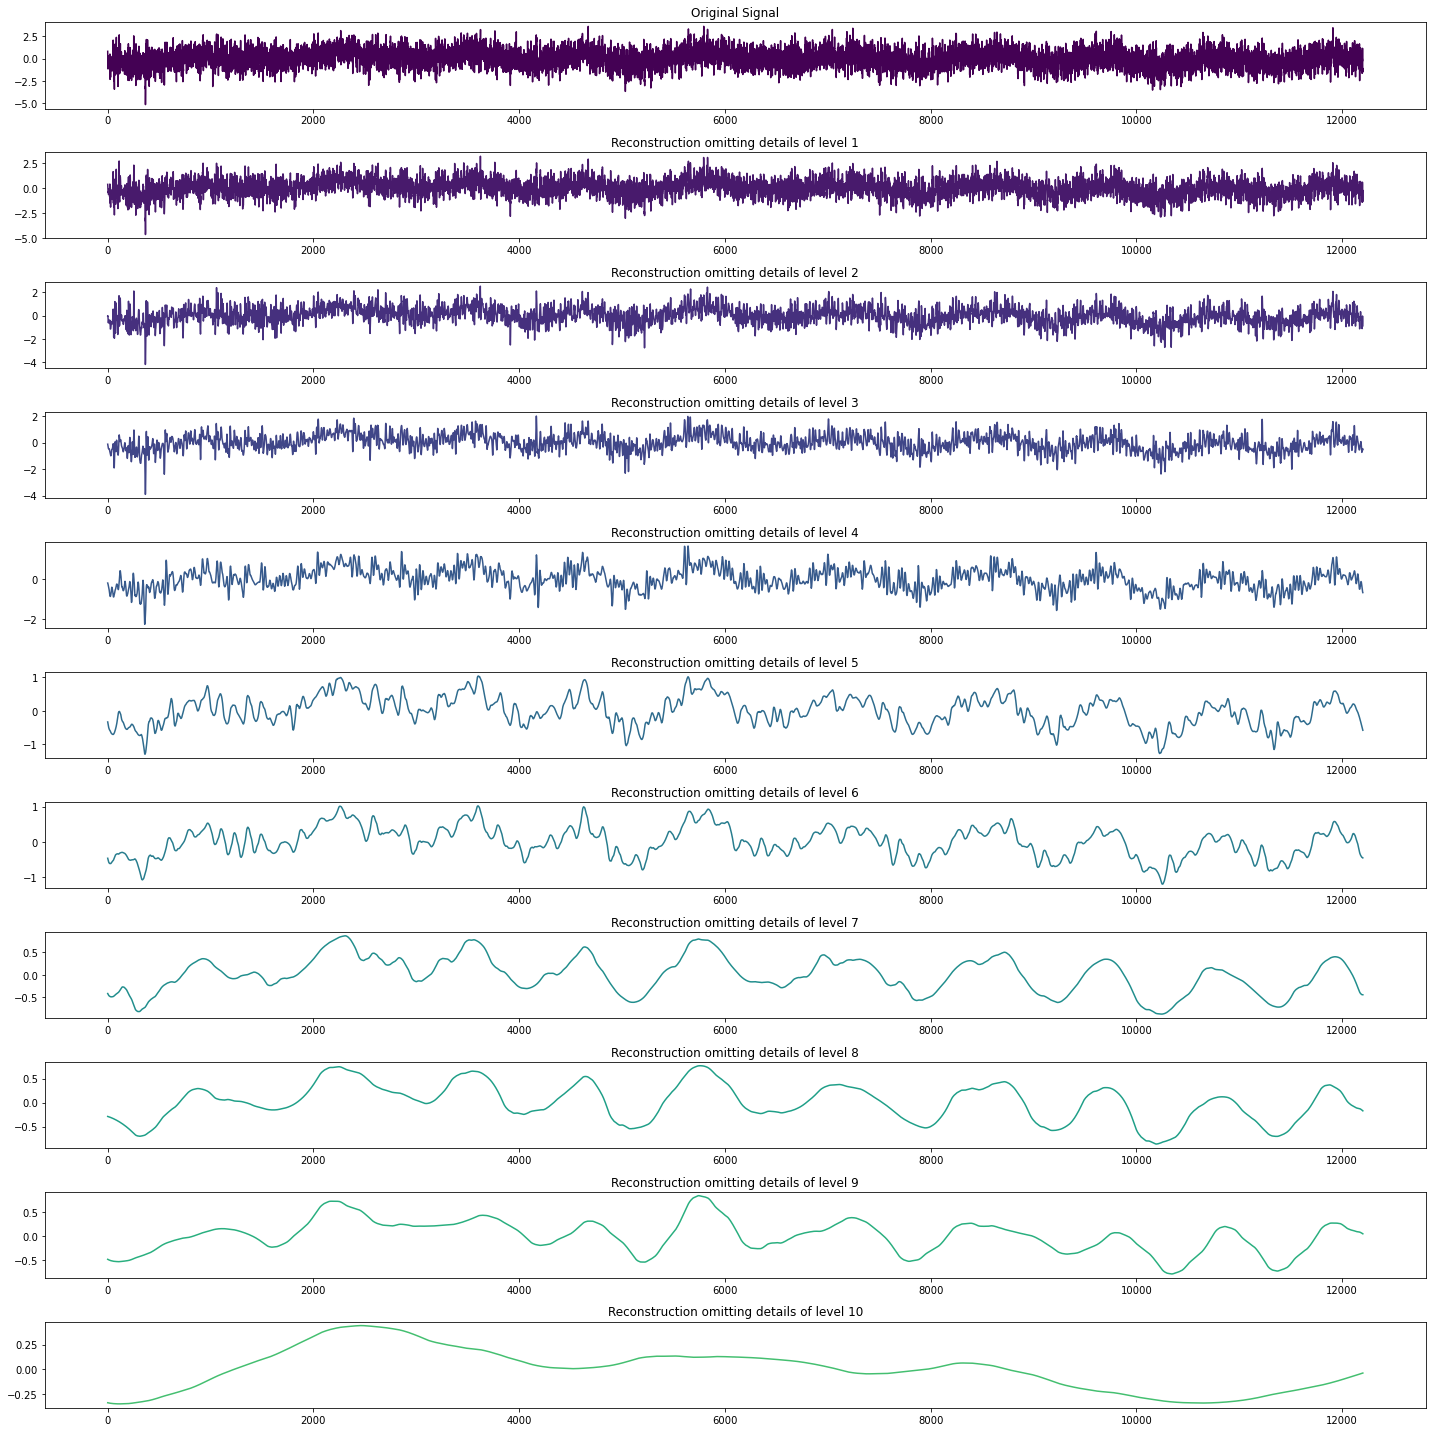

In [78]:
wvlet='db4'   # daubechies 4 wavelet
column = 'AccX' # using AccX values
data = df[column].values
data = (data - np.mean(data))/np.std(data)
mode = 'reflect' # mode defines the padding rule to extend the signal in order to properly apply the coefficients at each level.
              # VERY IMPORTANT! DEFINES ARTIFACTS AT THE EDGES OF THE SIGNAL
# --------------- DECOMPOSITION

w=pywt.wavedec(data,wvlet,mode=mode) # this function applies the DWT decomposition up to the maximum possible level
                                             # w is then a list of arrays, the first one being the approximation coefficients
                                             # at level n and the rest being the n,n-1,... details coefficients.

#just to be sure, let's grab the levels of reconstruction through the same function pywt uses
n_max=pywt.dwt_max_level(len(data),wvlet)


# --------------- RECONSTRUCTION
# let's plot different reconstruction levels
from matplotlib import cm
colors=[cm.viridis(x) for x in np.linspace(0,0.7,n_max+1)]
fig,axs=plt.subplots(n_max+1,figsize=[20,20])
# first axis we plot the entire reconstruction
x_re = pywt.waverec(w,wvlet,mode=mode)
axs[0].plot(x_re,color=colors[0])
axs[0].set_title("Original Signal")
w_n=w.copy()

for level in range(1,n_max+1):
                                                 # w[-i] are the detail coefficients for lvl i transformation.
    w_n[-level] = np.zeros_like(w_n[-level]) # at each iteration, we ignore the i-th level of detail
    x_re=pywt.waverec(w_n,wvlet,mode=mode)
    axs[level].plot(x_re,color=colors[level])
    axs[level].set_title("Reconstruction omitting details of level "+str(level))

fig.tight_layout()
plt.show()


The previous plot shows the progressing levels of wavelet decomposition for our signal. Now for the main problem: *denoising*. We wish to ignore small contributions of detail since they probably account for noise: `pywt`'s `thresholding` helper has routines that implement the most popular signal thresholding functions. First, let's do some explorative analysis on the details coefficients in order to get a good feeling of them. 

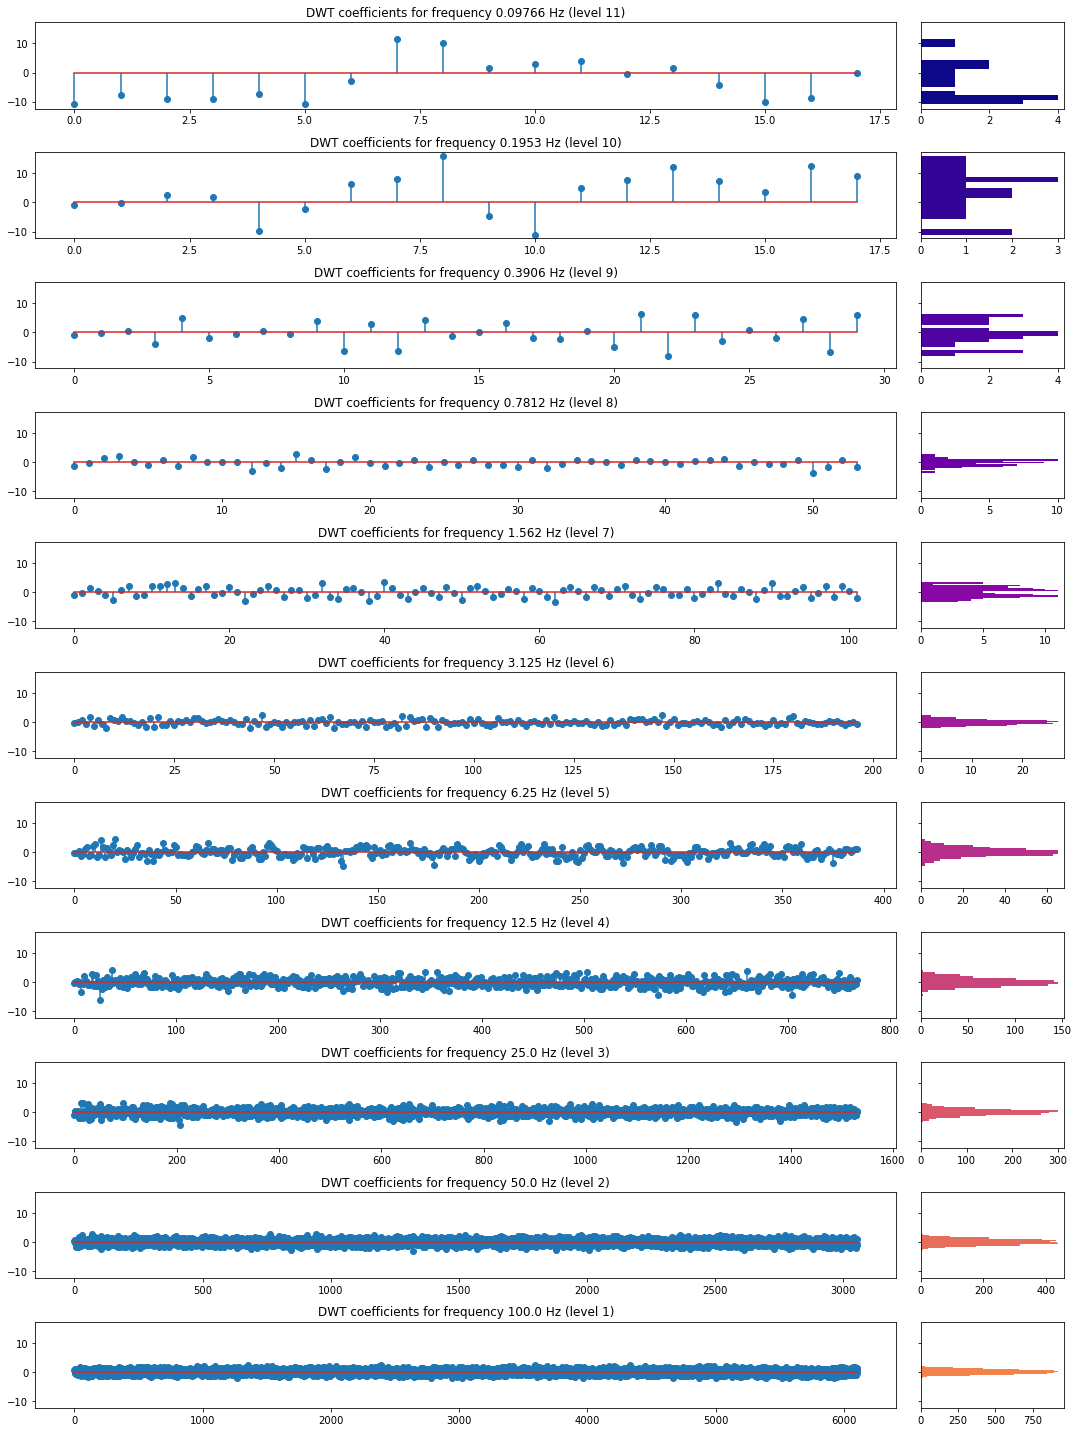

In [79]:
def plot_coefficients(w,sampling_rate,figsize=[15,20]):
    """
    This function take a list of DWT coefficients and plots the distribution at each level;
    designed to work with pywt's DWT implementation.
    Arguments:
    w : python list of numpy array like [cAn,cDn,cDn-1,...] is the list of coefficents, where w[0]=cAn is the largest scale (lowest frequency) coefficients
    sampling_rate : float, representing the sampling rate of the original signal. Serves to correctly assign frequency values for each scale.
    figsize : list [x,y] telling figure size
    """    
    n_plots = len(w)
    fig,axs = plt.subplots(n_plots,2,figsize=figsize,gridspec_kw={'width_ratios': [6, 1]},sharey=True)
    colors=[cm.plasma(x) for x in np.linspace(0,0.7,n_plots)]
    # maximum decomposition frequency (corresponding to smallest scale, i.e. last item in coefs list) is, by nyquist's rule, half the sampling rate.
    frequencies = [sampling_rate/(2**i) for i in range(n_plots,0,-1)] #build it to match w's order
    for id in range(n_plots):
        axs[id,0].stem(w[id],markerfmt='C0o')
        axs[id,0].set_title("DWT coefficients for frequency {:.4} Hz (level {})".format(frequencies[id],n_plots-id))
        axs[id,1].hist(w[id],bins=15,orientation='horizontal',color=colors[id])
    fig.tight_layout()
    plt.show()

plot_coefficients(w,sampling_rate)

/home/zano/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum frequency 
0.1639209900827801  Hz


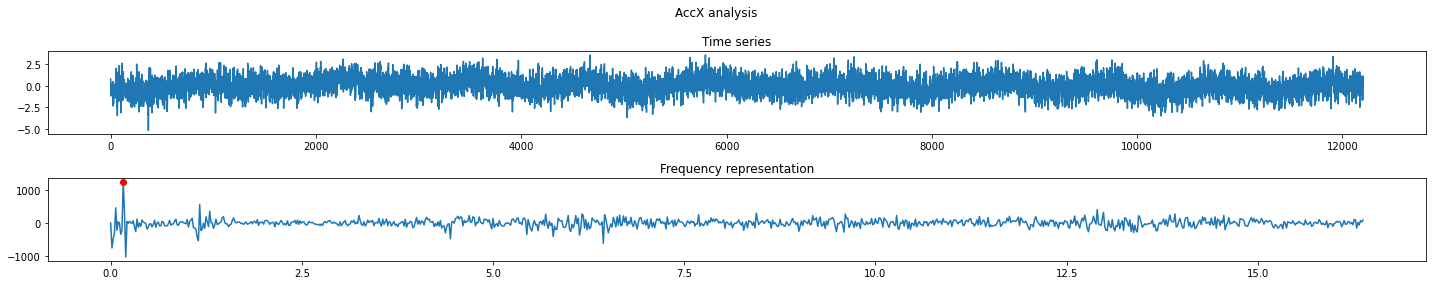

In [115]:
data = df['AccX'].values
data = (data-np.mean(data))/np.std(data)

fig,axs = plt.subplots(2,1,figsize=[20,4])
fig.suptitle("AccX analysis")
axs[0].plot(data)
axs[0].set_title("Time series")
dataFT = fft.fft(data)
dataFTfreq = fft.fftfreq(len(data),1/sampling_rate)
mask=np.where(dataFTfreq>=0)
n=1000
axs[1].set_title("Frequency representation")
axs[1].plot(dataFTfreq[mask][:n],dataFT[mask][:n])
imax = np.argmax(dataFT[mask])
axs[1].plot(dataFTfreq[mask][imax],dataFT[mask][imax],'ro')
print("Maximum frequency ")
print(dataFTfreq[mask][imax]," Hz")
fig.tight_layout()
